# Data Analytics - Lab 4 - Linear models

<span style="font-size: 20px;">
Konrad Prokop, 408687
</span>

In [72]:
from cmdstanpy import CmdStanModel
import arviz as az
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


## Excercise 1 - Modelling height of !Kung people

In [73]:
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/Experimental/data"
HOWELL_DATASET_PATH = f"{_BASE_URL}/Howell1.csv"
d = pd.read_csv(HOWELL_DATASET_PATH, sep=';', header=0)
d=d[d.age>=18] #just adults 
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [74]:
with open('height_1_ppc.stan', 'r') as f:

   print(f.read())

generated quantities {
    real mean_height = normal_rng(175, 10);
    real ad_height = normal_rng(10, 5);
    real sampled_height = normal_rng(mean_height, ad_height);
}


In [75]:
model_ppc=CmdStanModel(stan_file='height_1_ppc.stan')

R = 1000
sim=model_ppc.sample(iter_sampling=R,
                     iter_warmup=1,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [76]:
df = sim.draws_pd().iloc[:, -3:]
df.head()

,mean_height,ad_height,sampled_height
0,202.082,13.88590,184.415
1,176.276,3.05289,177.027
2,186.987,21.32670,207.692
3,180.554,12.99470,180.268
4,188.120,8.28937,185.541


Text(0, 0.5, 'Density')

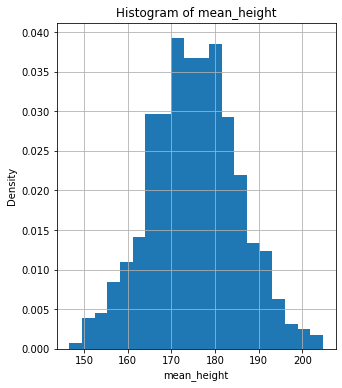

In [77]:
plt.figure(figsize=(5, 6))
plt.hist(df['mean_height'], bins=20, density=True)
plt.title('Histogram of mean_height')
plt.xlabel('mean_height')
plt.grid()
plt.ylabel('Density')

Text(0, 0.5, 'Density')

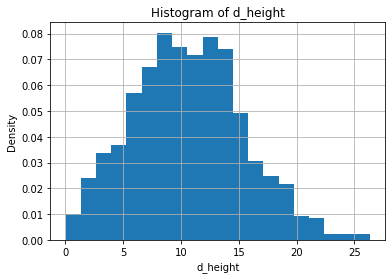

In [78]:
plt.hist(df['ad_height'], bins=20, density=True)
plt.title('Histogram of d_height')
plt.xlabel('d_height')
plt.grid()
plt.ylabel('Density')

Text(0, 0.5, 'Density')

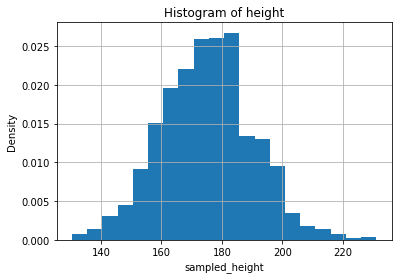

In [79]:
plt.hist(df['sampled_height'], bins=20, density=True)
plt.title('Histogram of height')
plt.xlabel('sampled_height')
plt.grid()
plt.ylabel('Density')

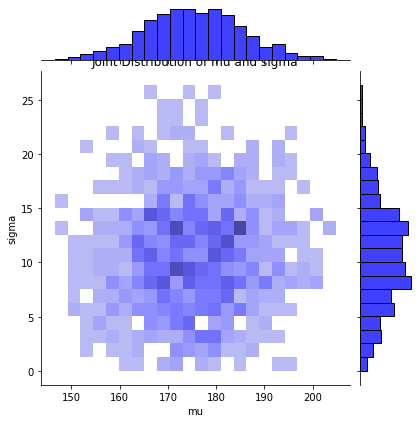

In [80]:
sns.jointplot(x=df['mean_height'], y=df['ad_height'], kind="hist", color="blue")
plt.title('Joint Distribution of mu and sigma')
plt.xlabel('mu')
plt.ylabel('sigma')
plt.show()

Text(0, 0.5, '')

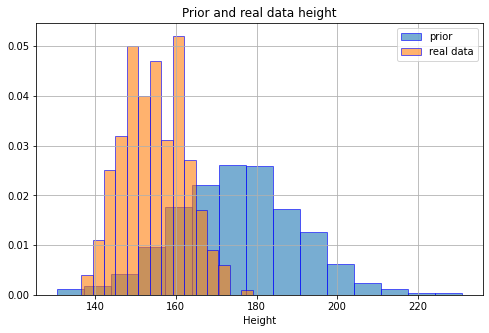

In [81]:
plt.figure(figsize=(8, 5))
plt.hist(df['sampled_height'], bins=15, density=True, label='prior', alpha=0.6, edgecolor='blue')
plt.hist(d['height'], bins=15, density=True, label='real data', alpha=0.6, edgecolor='blue')
plt.title('Prior and real data height')
plt.xlabel('Height')
plt.grid()
plt.legend()
plt.ylabel('')

## Excercise 2 - Model fit and evaluation

In [82]:
model_1_fit=CmdStanModel(stan_file='height_1_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [83]:
fit=model_1_fit.sample(data=dict(N=len(d),
                                   heights=d.height.values),
                         seed=28052020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [84]:
df1 = fit.draws_pd().iloc[:, -3:]
df1.head()

,mu,sigma,height
0,154.789,7.81211,159.879
1,155.223,8.59083,168.331
2,154.652,7.98702,151.856
3,154.702,7.46877,152.112
4,155.236,7.61466,168.144


<Figure size 2880x2880 with 0 Axes>

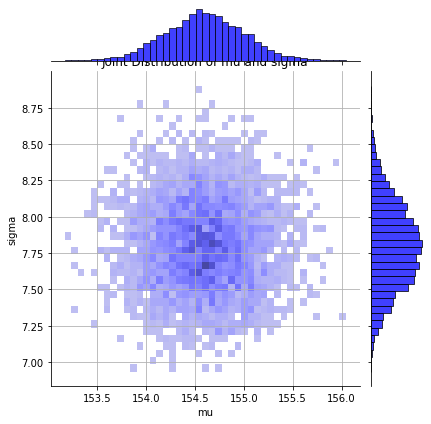

In [107]:
plt.figure(figsize=(8, 8))
sns.jointplot(x=df1['mu'], y=df1['sigma'], kind="hist", color="blue", fill=True)
plt.title('Joint Distribution of mu and sigma')
plt.xlabel('mu')
plt.ylabel('sigma')
plt.grid()
plt.show()

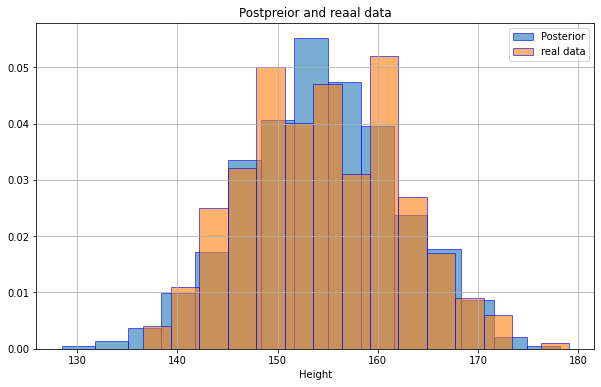

In [108]:
plt.figure(figsize=(10, 6))
plt.hist(df1['height'], bins=15, density=True, label='Posterior', alpha=0.6,edgecolor='blue')
plt.hist(d['height'], bins=15, density=True, label='real data', alpha=0.6, edgecolor='blue')
plt.title('Postpreior and real data')
plt.xlabel('Height')
plt.grid()
plt.legend()

## Excercise 3 - Adding predictor to the model - weight

In [109]:
d['c_weight'] = d['weight'] - d['weight'].mean()
data_sim={'N':50, 'weights':np.linspace(d.c_weight.min(),d.c_weight.max(), 50)}
print(d)

      height     weight   age  male   c_weight
0    151.765  47.825606  63.0     1   2.835121
1    139.700  36.485807  63.0     0  -8.504679
2    136.525  31.864838  65.0     0 -13.125648
3    156.845  53.041914  41.0     1   8.051429
4    145.415  41.276872  51.0     0  -3.713614
..       ...        ...   ...   ...        ...
534  162.560  47.031821  27.0     0   2.041335
537  142.875  34.246196  31.0     0 -10.744290
540  162.560  52.163080  31.0     1   7.172594
541  156.210  54.062497  21.0     0   9.072011
543  158.750  52.531624  68.0     1   7.541138

[352 rows x 5 columns]


## Excercise 4 - Prior predictive checks

In [110]:
model_ppc=CmdStanModel(stan_file='height_2a_ppc.stan')
R = 1000
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=1000, 
                     iter_warmup=1, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status

chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [111]:
df2 = sim.draws_pd()
df2.head()

,lp__,accept_stat__,alpha,beta,sigma,height[1],height[2],height[3],height[4],height[5],...,height[41],height[42],height[43],height[44],height[45],height[46],height[47],height[48],height[49],height[50]
0,0.0,0.0,182.082,0.777181,23.208300,174.2250,139.524,177.989,200.603,225.864,...,218.502,235.720,228.256,199.067,161.455,181.549,188.238,212.785,202.188,211.010
1,0.0,0.0,143.011,-0.006780,0.086958,143.2110,143.167,143.161,143.194,143.193,...,143.161,142.922,142.841,142.902,142.828,142.951,142.811,142.889,143.007,142.882
2,0.0,0.0,150.730,-1.138640,20.358900,195.4180,162.006,161.832,176.674,171.632,...,172.511,109.182,166.234,141.527,173.808,133.401,152.715,140.857,130.163,134.579
3,0.0,0.0,145.179,-0.254452,6.415610,157.2470,144.322,146.991,142.107,146.642,...,145.673,142.918,144.272,150.799,138.606,138.186,146.822,137.857,143.366,138.311
4,0.0,0.0,145.066,1.671020,9.955320,95.8198,117.007,116.179,117.368,139.047,...,181.001,179.489,160.252,170.393,168.335,166.305,166.594,180.516,179.787,167.046


In [112]:
alpha_samples = df2['alpha']
beta_samples = df2['beta']

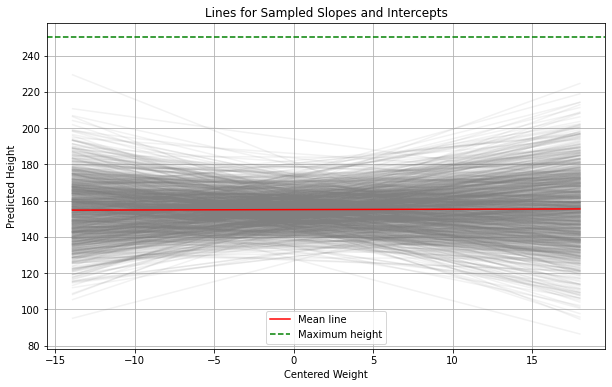

In [113]:
d['c_weight'] = d['weight'] - d['weight'].mean()
x = np.linspace(d['c_weight'].min(), d['c_weight'].max(), 100)

plt.figure(figsize=(10, 6))
for i in range(len(alpha_samples)):
    y = alpha_samples[i] + beta_samples[i] * x
    plt.plot(x, y, alpha=0.1, color='gray')

mean_alpha = alpha_samples.mean()
mean_beta = beta_samples.mean()
y_mean = mean_alpha + mean_beta * x
plt.plot(x, y_mean, color='red', label='Mean line')

plt.axhline(y=250, color='green', linestyle='--', label='Maximum height')

plt.xlabel('Centered Weight')
plt.ylabel('Predicted Height')
plt.title('Lines for Sampled Slopes and Intercepts')
plt.legend()

plt.grid(True)
plt.show()

## Excercise 5 - Modifying prior

In [114]:

model_ppc=CmdStanModel(stan_file='height_2b_ppc.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [115]:
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=1, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


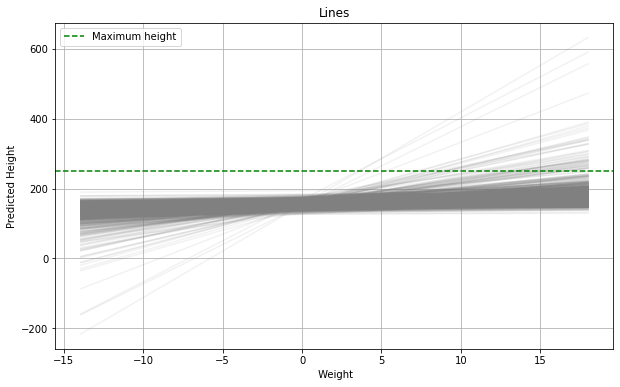

In [116]:
alpha_samples = sim.stan_variable('alpha')
beta_samples = sim.stan_variable('beta')

x = np.linspace(d['c_weight'].min(), d['c_weight'].max(), 100)

plt.figure(figsize=(10, 6))
for i in range(len(alpha_samples)):
    y = alpha_samples[i] + beta_samples[i] * x
    plt.plot(x, y, alpha=0.1, color='gray')


plt.axhline(y=250, color='green', linestyle='--', label='Maximum height')

plt.xlabel(' Weight')
plt.ylabel('Predicted Height')
plt.title('Lines')
plt.legend()

plt.grid(True)
plt.show()

In [117]:
df3 = sim.draws_pd()
heights_50 = df3.iloc[:, -50:]
heights_50.head()

,height[1],height[2],height[3],height[4],height[5],height[6],height[7],height[8],height[9],height[10],...,height[41],height[42],height[43],height[44],height[45],height[46],height[47],height[48],height[49],height[50]
0,167.672,63.2235,176.215,242.098,315.846,226.745,198.272,201.459,158.813,251.009,...,246.371,296.219,272.716,184.647,71.5476,129.943,148.498,220.128,187.311,212.209
1,163.741,155.8910,156.170,165.002,166.306,159.061,159.291,115.113,188.629,173.597,...,216.921,167.219,151.522,166.047,151.8400,179.894,151.486,169.707,196.567,171.451
2,151.037,138.1720,138.591,145.012,143.485,147.654,123.362,142.650,122.707,136.292,...,161.420,136.598,159.888,150.502,163.8920,148.231,156.439,152.188,148.402,150.655
3,164.144,134.5110,141.575,130.863,142.317,160.506,157.025,161.092,153.258,132.511,...,168.193,162.491,166.459,182.600,154.6890,154.484,175.589,155.275,169.021,157.908
4,129.719,157.1870,154.922,155.380,183.513,177.513,174.023,185.696,174.025,178.172,...,198.860,195.670,168.541,181.090,177.1630,173.273,172.515,190.171,188.039,169.683


In [118]:
variable_names = sim.column_names


## Excercise 6 - Fitting and evaluating model

In [119]:
model_2_fit=CmdStanModel(stan_file='height_2_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [120]:
data_fit = {'N':50, 'weights':d.weight[:50], 'heights':d.height[:50]}
fit=model_2_fit.sample(data=data_fit,seed=28052020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [121]:
df4 = fit.draws_pd()
df4.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,sigma,alpha,beta,...,sampled_height[41],sampled_height[42],sampled_height[43],sampled_height[44],sampled_height[45],sampled_height[46],sampled_height[47],sampled_height[48],sampled_height[49],sampled_height[50]
0,-122.134,0.887560,0.123099,4.0,31.0,0.0,126.425,7.10688,129.291,0.535556,...,143.489,161.762,142.887,163.210,149.847,162.812,141.806,157.737,146.557,149.578
1,-122.152,0.998586,0.123099,3.0,7.0,0.0,122.236,7.11688,129.496,0.528728,...,149.285,155.559,150.344,156.647,157.857,151.120,148.707,157.458,174.119,160.798
2,-118.534,0.986296,0.123099,5.0,31.0,0.0,122.978,5.40232,124.786,0.639963,...,160.563,165.998,158.574,151.396,165.458,158.915,159.295,149.864,153.493,144.089
3,-118.600,0.961395,0.123099,2.0,3.0,0.0,118.829,5.35957,124.398,0.626490,...,159.578,158.238,150.058,157.724,155.299,156.890,151.006,153.473,158.051,159.798
4,-118.447,0.965926,0.123099,4.0,27.0,0.0,119.723,5.03929,120.861,0.706481,...,150.993,157.377,152.221,157.506,160.323,161.259,154.307,155.297,157.231,156.320


In [122]:
alpha = df4['alpha']
beta = df4['beta']
x = data_fit['weights']
plt.figure(figsize=(20, 10))
for i in range(99, len(alpha), 100):
     plt.plot(x, alpha[i] + x * beta[i], alpha=1, label=f'{i+1} sample')

plt.grid()
plt.title('Lines')
plt.xlabel('Weight')
plt.ylabel('Height')
plt.legend()

In [ ]:

print(df4.columns)

Index(['lp__', 'accept_stat__', 'stepsize__', 'treedepth__', 'n_leapfrog__',
       'divergent__', 'energy__', 'sigma', 'alpha', 'beta',
       ...
       'sampled_height[41]', 'sampled_height[42]', 'sampled_height[43]',
       'sampled_height[44]', 'sampled_height[45]', 'sampled_height[46]',
       'sampled_height[47]', 'sampled_height[48]', 'sampled_height[49]',
       'sampled_height[50]'],
      dtype='object', length=110)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


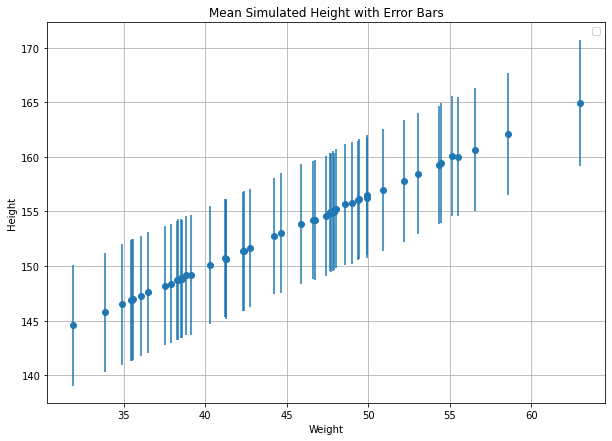

In [ ]:
mean_height = df4[[f'sampled_height[{i}]' for i in range(1, 51)]].mean(axis=0)

std_height = df4[[f'sampled_height[{i}]' for i in range(1, 51)]].std(axis=0)

observed_weight = data_fit['weights']
observed_height = data_fit['heights']

plt.figure(figsize=(10, 7))

plt.errorbar(observed_weight, mean_height, yerr=std_height, fmt='o')


plt.grid()
plt.title('Mean Simulated Height with Error Bars')
plt.xlabel('Weight')
plt.ylabel('Height')
plt.legend()
plt.show()

## Excercise 7 - Extending the model

In [ ]:
N = 50
data_fit = {'N':N, 'weights':d.c_weight[:N], 'heights':d.height[:N]}
fit=model_2_fit.sample(data=data_fit,seed=28052020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [ ]:
df4 = fit.draws_pd()
df4.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,sigma,alpha,beta,...,sampled_height[41],sampled_height[42],sampled_height[43],sampled_height[44],sampled_height[45],sampled_height[46],sampled_height[47],sampled_height[48],sampled_height[49],sampled_height[50]
0,-107.139,0.930076,0.906818,2.0,7.0,0.0,107.299,4.99335,153.213,0.750333,...,153.198,159.540,151.381,154.804,156.671,155.432,152.209,149.098,161.474,149.510
1,-107.275,0.994484,0.906818,2.0,3.0,0.0,107.586,4.68621,152.669,1.012890,...,158.988,165.234,153.409,153.697,155.383,160.230,158.773,155.229,153.187,150.890
2,-106.598,0.950710,0.906818,2.0,3.0,0.0,107.999,4.58491,152.652,0.815351,...,147.113,166.474,154.294,156.281,155.993,162.268,152.245,157.196,154.409,155.926
3,-106.921,0.972437,0.906818,2.0,3.0,0.0,107.348,4.66242,153.494,0.970220,...,158.245,168.071,162.630,154.170,161.749,162.624,153.299,153.104,164.430,152.604
4,-106.789,0.981528,0.906818,2.0,3.0,0.0,107.185,5.14853,152.725,0.792171,...,153.473,159.109,155.410,155.281,160.127,167.737,155.145,151.418,163.343,157.182


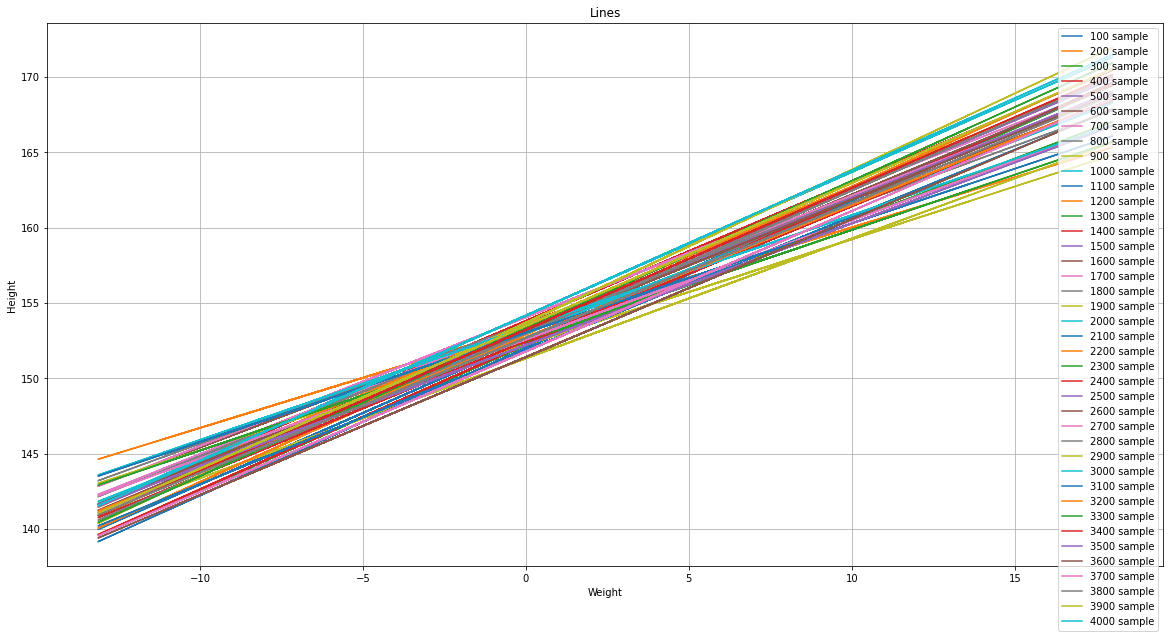

In [ ]:
alpha = df4['alpha']
beta = df4['beta']
x = data_fit['weights']
plt.figure(figsize=(20, 10))
for i in range(99, len(alpha), 100):
     plt.plot(x, alpha[i] + x * beta[i], alpha=1, label=f'{i+1} sample')

plt.grid()
plt.title('Lines')
plt.xlabel('Weight')
plt.ylabel('Height')
plt.legend()

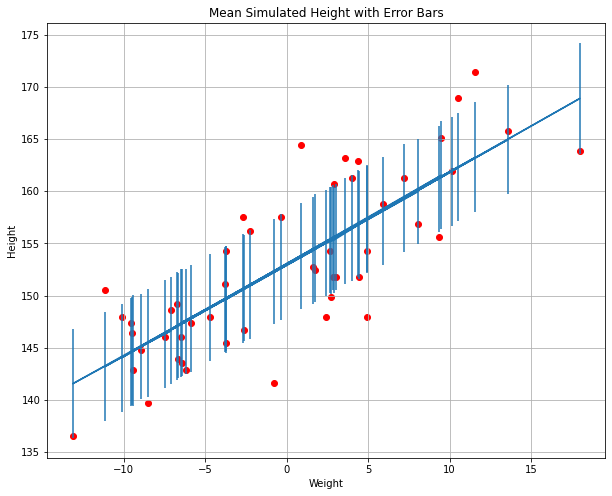

In [ ]:
heights_mean = df4.iloc[:, -50:].mean(axis=0)
plt.figure(figsize=(10,8))

plt.errorbar(data_fit['weights'], heights_mean, yerr=np.std(df4.iloc[:, -50:]))

plt.scatter(data_fit['weights'], data_fit['heights'], color='red')

plt.xlabel('Weight')
plt.ylabel('Height')
plt.title('Mean Simulated Height with Error Bars')
plt.grid(True)
plt.show()